Standard vs nevh: simulation of single orbit of Halley's comet. Compare final angular momentum, final energy and perihelion distance in both approaches. Eventually further information can be obtained comparing with analytical values for these quantities.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
PI = np.pi
sys.path.append("../src")
import nevh

In [2]:
# Plain rk4, to compare calculations using the same integrator, with the same integration step.
def rk4pl(t, y, dt, f, *params):
    k1 = f(t, y, *params)
    k2 = f(t + dt/2, y + k1 * dt/2, *params)
    k3 = f(t + dt/2, y + k2 * dt/2, *params)
    k4 = f(t + dt, y + k3 * dt, *params)
    return ((k1 + 2*k2+ 2*k3 + k4) * dt/6)

In [3]:
#1D harmonic oscilator
def f(t, y, w2):
    x, v = y
    return np.array([v, -w2*x])

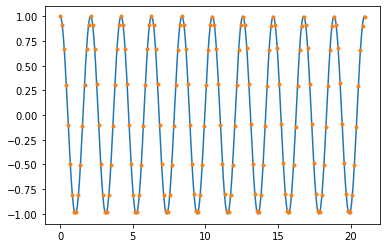

In [26]:
w = 3.0
w2 = w**2
n = 150
tmax = 10 * 2*PI/w
dt = tmax / n
t = np.linspace(0,tmax,n+1)
yn = np.zeros((n+1, 2))
x0 = 1.0; v0 = 0.0
yn[0] = (x0, v0)
for i,y in enumerate(yn[:-1]):
    yn[i+1] = y + rk4pl(i*dt, y, dt, f, w2)
A = x0; B = v0/w
tcont = np.linspace(0,tmax,600)
ycont = A*np.cos(w*tcont) + B * np.sin(w*tcont)
plt.plot(tcont,ycont, t,yn[:,0],'.');

### Central force: Kepler orbit

In [27]:
# rhs for eqs of motion (cartesian coordinates)
def fkep(t, Psi, GM, mu):
    x, y, px, py = Psi
    r3 = (x**2 + y**2)**1.5
    return np.array([ px/mu, py/mu, -GM*mu*x/r3, -GM*mu*y/r3])

In [28]:
# Hamiltonian (cartesian coordinates)
def Hkep(t, psi, GM, mu):
    x, y, px, py = psi
    return (px**2 + py**2)/(2*mu) - GM*mu / (x**2 + y**2)**0.5

In [40]:
# Global physical parameters
GM = 39.426900 # AU^3/y^2
mu = 2.2       # 10^14 kg (Halley)
alpha = GM*mu

# Initial state (Halley's comet data)
xf = 35.082 #(apheliom)
xc = 0.586  #/periheliom
vf = (2*GM*(1/xc - 1/xf)/((xf/xc)**2-1))**0.5

# Angular momentum and energy
l = mu * xf * vf
E = mu * vf**2 / 2 - alpha / xf

# Eccentricity, semimajor axis
eps = (1 + 2*E*l**2/(mu*alpha**2))**0.5
a = (xc + xf) / 2

# Orbital period
T = (4*PI**2 * a**3/GM)**0.5

# Numerical parameters
N = 4500
dt = T / (N-1)
t = np.linspace(0, T, N)

# Standard approach
psi_s = np.zeros((N,4))
psi_s[0] = [xf, 0.0, 0.0, mu*vf]
for i, psi in enumerate(psi_s[:-1]):
    psi_s[i+1] = psi + rk4pl(i*dt, psi, dt, fkep, GM, mu)
    
# nevh
dpsi = np.array([0.001, 0.001, 0.1,0.1])
gkep = nevh.Hgrad(Hkep, dpsi, GM=GM, mu=mu)
psi_n = np.zeros_like(psi_s)
psi_n[0] = [xf, 0.0, 0.0, mu*vf]
for i, psi in enumerate(psi_n[:-1]):
    psi_n[i+1] = psi + rk4pl(i*dt, psi, dt, gkep)

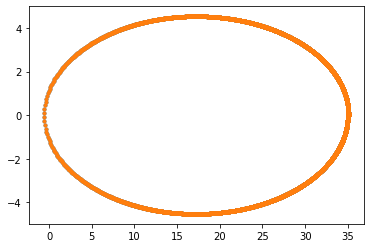

In [41]:
plt.plot(psi_s[:,0], psi_s[:,1], '.', psi_n[:,0],psi_n[:,1],'.');

In [42]:
# standard
x,y,px,py = psi_s[-1]
ps = min([psi[0]**2+psi[1]**2 for psi in psi_s])**0.5
lfs = x * py - y * px
efs = (px**2+py**2)/(2*mu) - alpha/(x**2+y**2)**0.5
# nevh
x,y,px,py = psi_n[-1]
pn = min([psi[0]**2+psi[1]**2 for psi in psi_n])**0.5
lfn = x*py-y*px
efn = (px**2+py**2)/(2*mu) - alpha/(x**2+y**2)**0.5
print("Init: {:9.4f} {:9.4g} {:9.4g} {:9.4g}".format(*psi_s[0]))
print("Stdr: {:9.4f} {:9.4g} {:9.4g} {:9.4g}".format(*psi_s[-1]))
print("Nevh: {:9.4f} {:9.4g} {:9.4g} {:9.4g}".format(*psi_n[-1]))
#print(psi_s[0])
#print(psi_s[-1])
#print(psi_n[-1])
print("th: {:.6f} {:.6f} {:.6f}".format(xc, l, E))
print("st: {:.6f} {:.6f} {:.6f}".format(ps,lfs,efs))
print("nv: {:.6f} {:.6f} {:.6f}".format(pn,lfn,efn))

Init:   35.0820         0         0    0.4228
Stdr:   34.9920   0.03259  -0.01013    0.4238
Nevh:   34.9920    0.0326  -0.01013    0.4238
th: 0.586000 14.831518 -2.431849
st: 0.589861 14.831272 -2.437980
nv: 0.589861 14.831272 -2.437980


In [43]:
# Again, but now for error plots
# Global physical parameters
GM = 39.426900 # AU^3/y^2
mu = 2.2       # 10^14 kg (Halley)
alpha = GM*mu

# Initial state (Halley's comet data)
xf = 35.082 #(apheliom)
xc = 0.586  #/periheliom
vf = (2*GM*(1/xc - 1/xf)/((xf/xc)**2-1))**0.5

# Angular momentum and energy
l = mu * xf * vf
E = mu * vf**2 / 2 - alpha / xf
# Eccentricity, semimajor axis
eps = (1 + 2*E*l**2/(mu*alpha**2))**0.5
a = (xc + xf) / 2
# Orbital period
T = (4*PI**2 * a**3/GM)**0.5

# Numerical parameters
N = 14000
dt = T / (N-1)
t = np.linspace(0, T, N)
# Standard approach
psi_s = np.zeros((N,4))
psi_s[0] = [xf, 0.0, 0.0, vf]
for i, psi in enumerate(psi_s[:-1]):
    psi_s[i+1] = psi + rk4pl(i*dt, psi, dt, fkep, GM, mu)

x, y, px, py = psi_s[-1]
# final angular momentum, final energy, perihelion
l_s = x*py - y*px
E_s = (px**2+ py**2)/(2*mu) - alpha / (x**2+y**2)**0.5
p_s = min([r[0]**2 + r[1]**2 for r in psi_s])**0.5

#nevh
dpsi = np.array([0.001, 0.001, 0.001,0.001])
gkep = nevh.Hgrad(Hkep, dpsi, GM=GM, mu=mu)
psi_n = np.zeros_like(psi_s)
psi_n[0] = [xf, 0.0, 0.0, mu*vf]
for i, psi in enumerate(psi_n[:-1]):
    psi_n[i+1] = psi + rk4pl(i*dt, psi, dt, gkep)